In [1]:
import numpy as np
import pandas as pd
import codecs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [2]:
from bs4 import BeautifulSoup
import urllib.request
import time

In [3]:
def getstockfromweb():
  page_num = 20 # 取得するページ数
  tstock = []
  for i in range(page_num):
    # Yahoo Financeのページを利用
    url = "https://finance.yahoo.co.jp/quote/998407.O/history?from=20170101&to=20211231&timeFrame=d&page=" + str(i+2)
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    estock = [value.get_text() for value in soup.find_all("td")[0:100]]
     #<td></td>に欲しい数値が文字で入っているのでその部分を抽出し、get_textで文字のみさらに抽出する
    tstock.extend(estock) # appendではなく一つの大きな配列にするためextendを使う
    time.sleep(0.1) # どんどんデータをとると、サーバが察知してデータが取れなくなる
  tstock = np.array(tstock) # NumPyへ変換
  stock = tstock.reshape(-1, 5)
  stock = pd.DataFrame(stock, columns=['date', 'open', 'max', 'min', 'close'], index=stock[:,0])
  stock = stock.drop('date',axis=1).apply(lambda x: x.str.replace(',','')).apply(lambda x: x.astype(np.float32))
  return stock
#  return stock.apply(lambda x: x.str.replace(',','')).astype(np.float32) # 文字を数字に変換
# この関数の実行を確認する場合は、次のコードセルを作成して実行するとよい
# stock = getstockfromweb()
# stock

In [4]:
def getstockdata():
  path = 'stockdata.csv'
  with codecs.open(path, "r", "Shift-JIS", "ignore") as f:
    stock = pd.read_table(f, delimiter=",", header=None, names=['date', 'open', 'max', 'min', 'close', 'total', 'adjustment'])
    stock = stock.drop(stock.index[[0,1]])[['open', 'max', 'min', 'close', 'total', 'adjustment']].apply(lambda x: x.astype(np.float32))
  return stock

In [5]:
whichdata = False # webスクレイピングを利用する、Falseでダウンロードデータを利用する
if whichdata==True:
  dfp = getstockfromweb()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open', 'max', 'min'])
else:
  import os
  if not os.path.exists('stockdata.csv'):
      #!wget "https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw" -O stockdata.csv
      !wget https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k -O stockdata.csv
  dfp = getstockdata()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open','max','min','total','adjustment'])
df

open          float32
max           float32
min           float32
close         float32
total         float32
adjustment    float32
dtype: object
       open     max     min   close     total  adjustment
2    2770.0  2776.0  2690.0  2690.0  462800.0      2690.0
3    2725.0  2751.0  2709.0  2750.0  240700.0      2750.0
4    2714.0  2727.0  2692.0  2711.0  275800.0      2711.0
5    2734.0  2756.0  2732.0  2749.0  213800.0      2749.0
6    2765.0  2773.0  2753.0  2755.0  175400.0      2755.0
..      ...     ...     ...     ...       ...         ...
150  2274.0  2285.0  2262.0  2276.0   88000.0      2276.0
151  2270.0  2291.0  2255.0  2255.0   86600.0      2255.0
152  2255.0  2255.0  2228.0  2228.0  126100.0      2228.0
153  2265.0  2290.0  2257.0  2271.0  217100.0      2271.0
154  2294.0  2294.0  2265.0  2276.0  133300.0      2276.0

[153 rows x 6 columns]


,close
0,2690.0
1,2750.0
2,2711.0
3,2749.0
4,2755.0
...,...
148,2276.0
149,2255.0
150,2228.0
151,2271.0


In [6]:
#訓練データとテストデータに分割
test_size = 0.3
sp = df['close'].values # pandasからnumpyへ変換
total_len = len(sp)
test_len = int(len(sp)*test_size)
train_len = total_len - test_len
print("total_len:", total_len, " train_len:", train_len, "test_len:", test_len)
train = sp[0:train_len]
test = sp[train_len:total_len]
x_max, x_min = max(sp), min(sp)
train_norm = (train - x_min) / (x_max - x_min)
test_norm = (test - x_min) / (x_max - x_min)

total_len: 153  train_len: 108 test_len: 45


In [7]:
#時系列データに分割
n_time = 6
x_train, y_train, x_test, y_test= [], [], [], []
for i in range(train_len-n_time):
  x_train.append(train_norm[i:i+n_time].reshape(-1,1))
  y_train.append(train_norm[i+n_time])
for i in range(test_len-n_time):
  x_test.append(test_norm[i:i+n_time])
  y_test.append(test_norm[i+n_time])

In [8]:
epochs = 50
batch_size = 32
train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換
train_correct_data = torch.tensor(y_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(train_input_data, train_correct_data)  # trainデータセットの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_input_data = torch.tensor(x_test, dtype=torch.float)  # テンソルに変換
test_correct_data = torch.tensor(y_test, dtype=torch.float)
test_dataset = torch.utils.data.TensorDataset(test_input_data, test_correct_data)  # testデータセットの作成
test_loader = DataLoader(test_dataset, batch_size=len(x_test))

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


<ipython-input-8-e7715137c3d5>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換


In [9]:
class GRUN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUN, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_gru, h = self.gru(x, None)
    y = self.fc(y_gru[:, -1, :])
    return y
model = GRUN(1, 100, 1).to(device)
print(model)

GRUN(
  (gru): GRU(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [10]:
def my_func ():
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  record_loss_train = []
  for i in range(epochs):
    for j, (x, t) in enumerate(train_loader):
      x, t = x.to(device), t.reshape(-1,1).to(device)
      y = model(x)
      loss = loss_func(y, t)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss /= j+1
    record_loss_train.append(loss)
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')
  sp_norm = sp/x_max
  in_true = list(sp_norm.reshape(-1).astype(np.float32)) # ここの意味を理解する
  pred = []
  model.eval()
  for i in range(n_time):
    pred.append(0) # 最初は予測できないので0を加える
  with torch.no_grad():
      for i in range(len(sp)-n_time):
        x = torch.tensor(in_true[i:i+n_time])  # 直近の時系列を取り出す
        x = x.reshape(1, -1, 1)  # (バッチサイズ, 時系列の数, 入力の数)
        y = model(x)
        pred.append(y[0].item())  # 予測結果をpredictedに追加する
  plt.plot(range(len(sp)), sp, label="Correct")
  pred = np.array(pred)
  pred = pred * x_max
  plt.plot(range(len(pred)), pred, label="Predicted")
  plt.legend()
  plt.show()
  return loss.item()

epoch:   0 loss: 0.00670110
epoch:   1 loss: 0.00364290
epoch:   2 loss: 0.00350983
epoch:   3 loss: 0.00357326
epoch:   4 loss: 0.00306136
epoch:   5 loss: 0.00363547
epoch:   6 loss: 0.00382158
epoch:   7 loss: 0.00198638
epoch:   8 loss: 0.00291415
epoch:   9 loss: 0.00209902
epoch:  10 loss: 0.00289623
epoch:  11 loss: 0.00179074
epoch:  12 loss: 0.00272988
epoch:  13 loss: 0.00140973
epoch:  14 loss: 0.00220969
epoch:  15 loss: 0.00124476
epoch:  16 loss: 0.00207356
epoch:  17 loss: 0.00114308
epoch:  18 loss: 0.00184168
epoch:  19 loss: 0.00093453
epoch:  20 loss: 0.00141635
epoch:  21 loss: 0.00088352
epoch:  22 loss: 0.00123301
epoch:  23 loss: 0.00083089
epoch:  24 loss: 0.00093522
epoch:  25 loss: 0.00080656
epoch:  26 loss: 0.00082546
epoch:  27 loss: 0.00079886
epoch:  28 loss: 0.00070963
epoch:  29 loss: 0.00079254
epoch:  30 loss: 0.00071157
epoch:  31 loss: 0.00071121
epoch:  32 loss: 0.00074037
epoch:  33 loss: 0.00069430
epoch:  34 loss: 0.00070935
epoch:  35 loss: 0.0

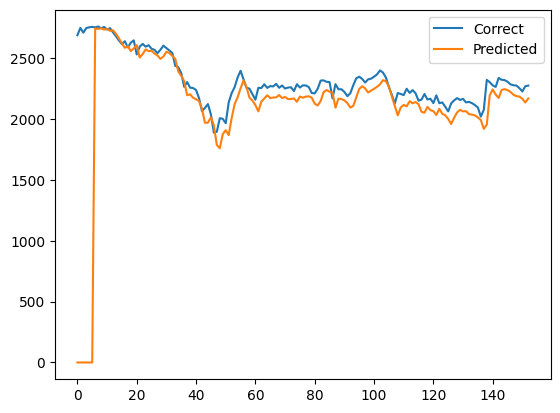

In [11]:
model = GRUN(1, 100, 1).to(device)
gru_loss = my_func()

In [12]:
class RNNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNNN, self).__init__()
    self.RNN = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_RNN, h = self.RNN(x, None)
    y = self.fc(y_RNN[:, -1, :])
    return y
model = RNNN(1, 100, 1).to(device)
print(model)

RNNN(
  (RNN): RNN(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


epoch:   0 loss: 0.00662792
epoch:   1 loss: 0.05815897
epoch:   2 loss: 0.00434805
epoch:   3 loss: 0.00768176
epoch:   4 loss: 0.00309521
epoch:   5 loss: 0.00560962
epoch:   6 loss: 0.00289826
epoch:   7 loss: 0.00566966
epoch:   8 loss: 0.00257477
epoch:   9 loss: 0.00643852
epoch:  10 loss: 0.00284907
epoch:  11 loss: 0.00554755
epoch:  12 loss: 0.00318172
epoch:  13 loss: 0.00419118
epoch:  14 loss: 0.00289339
epoch:  15 loss: 0.00404901
epoch:  16 loss: 0.00267367
epoch:  17 loss: 0.00404192
epoch:  18 loss: 0.00259179
epoch:  19 loss: 0.00401451
epoch:  20 loss: 0.00247852
epoch:  21 loss: 0.00392669
epoch:  22 loss: 0.00232404
epoch:  23 loss: 0.00372960
epoch:  24 loss: 0.00223713
epoch:  25 loss: 0.00353104
epoch:  26 loss: 0.00221010
epoch:  27 loss: 0.00323588
epoch:  28 loss: 0.00223701
epoch:  29 loss: 0.00283781
epoch:  30 loss: 0.00229762
epoch:  31 loss: 0.00250205
epoch:  32 loss: 0.00233999
epoch:  33 loss: 0.00226700
epoch:  34 loss: 0.00231035
epoch:  35 loss: 0.0

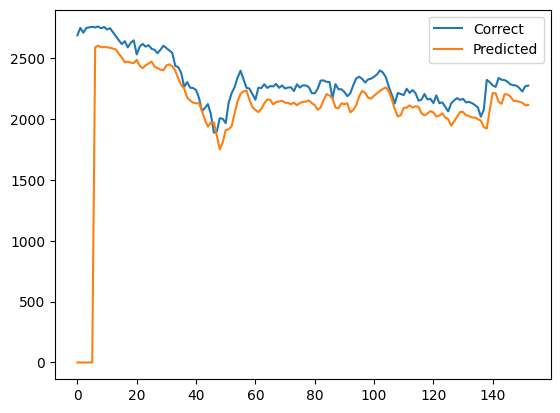

In [13]:
model = RNNN(1, 100, 1).to(device)
rnn_loss = my_func()

In [14]:
class LSTMN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMN, self).__init__()
    self.LSTM = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_LSTM, h = self.LSTM(x, None)
    y = self.fc(y_LSTM[:, -1, :])
    return y
model = LSTMN(1, 100, 1).to(device)
print(model)

LSTMN(
  (LSTM): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


epoch:   0 loss: 0.04384084
epoch:   1 loss: 0.00736062
epoch:   2 loss: 0.00395307
epoch:   3 loss: 0.00912694
epoch:   4 loss: 0.00287321
epoch:   5 loss: 0.00286330
epoch:   6 loss: 0.00647909
epoch:   7 loss: 0.00387613
epoch:   8 loss: 0.00281521
epoch:   9 loss: 0.00477453
epoch:  10 loss: 0.00311766
epoch:  11 loss: 0.00342594
epoch:  12 loss: 0.00280161
epoch:  13 loss: 0.00321366
epoch:  14 loss: 0.00261449
epoch:  15 loss: 0.00448588
epoch:  16 loss: 0.00255434
epoch:  17 loss: 0.00577642
epoch:  18 loss: 0.00286653
epoch:  19 loss: 0.00667563
epoch:  20 loss: 0.00302805
epoch:  21 loss: 0.00465384
epoch:  22 loss: 0.00251212
epoch:  23 loss: 0.00262344
epoch:  24 loss: 0.00388462
epoch:  25 loss: 0.00226593
epoch:  26 loss: 0.00367958
epoch:  27 loss: 0.00236828
epoch:  28 loss: 0.00434198
epoch:  29 loss: 0.00259695
epoch:  30 loss: 0.00388592
epoch:  31 loss: 0.00223076
epoch:  32 loss: 0.00234706
epoch:  33 loss: 0.00341492
epoch:  34 loss: 0.00202653
epoch:  35 loss: 0.0

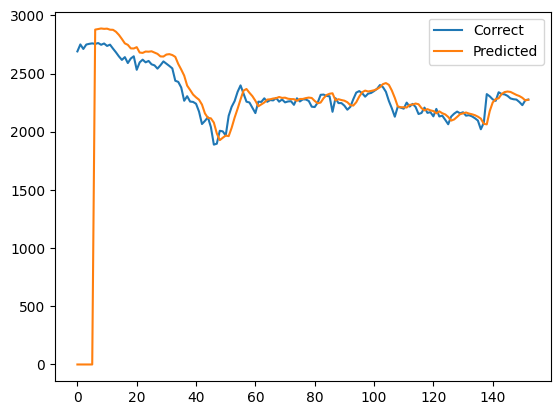

In [15]:
model = LSTMN(1, 100, 1).to(device)
lstm_loss = my_func()

In [17]:
print("GRU:",gru_loss,"RNN:",rnn_loss,"LSTM:",lstm_loss)

GRU: 0.0006365654990077019 RNN: 0.001496660290285945 LSTM: 0.0024770013988018036


3つの手法ですべてがエポックを重ねるとlossが小さくなった。また、今回のデータではGRU, RNN, LSTMの順で最終的なlossが小さくなった。